In [36]:
import bea_oecd_mapping as bo
import investment_recipe as ir
import international_network as inet
import json
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm

# Creating the International Investment Matrix

This notebook takes you through the construction of the international investment matrix for the Macro model. There are three major steps:

1. Creating a map between BEA data and the OECD's ICIO sectors
2. Creating a country-level investment network based on [VomLehn-Winberry's](https://www.nber.org/system/files/working_papers/w26507/w26507.pdf) methodology
3. Using the ICIO's fixed capital formation and the investment recipe to create an international matrix

## Preliminary Steps + Raw Data Paths

In [2]:
# this file is from BEA's detailed fixed asset tables https://apps.bea.gov/national/FA2004/Details/Index.htm
# make sure 2012 NAICS code column is in string format
expenditure_data = 'raw_data/detailnonres_inv1.xlsx'

# this is a map from the asset codes in the above table to nipa codes used in the bridge files
# this is taken from VW's code
asset_nipa = pd.read_csv("raw_data/nipa_asset_codes.csv")
asset_nipa = {r["asset_code"]: r["nipa_code"] for i, r in asset_nipa.iterrows()}

# this is a map from the asset codes into the sectors that VW assume produce them for IPP
ipp_map = pd.read_csv("raw_data/ipp_map.csv")
ipp_map = {r["asset_code"]: r["prod_sec"] for i, r in ipp_map.iterrows()}

# this file is a manually created map between bea and icio sectors
oecd_bea_crosswalk_path = 'raw_data/oecd_bea_crosswalk.csv'

# these are naics/isic mappings from the UN https://unstats.un.org/unsd/classifications/Econ/isic
naics_isic_path = "raw_data/NAICS_ISIC.csv"
isic_naics_path = "raw_data/ISIC_NAICS.csv"

# BEA IOT make and use tables for weighting the sectoral allocations of artistic originals
# and prepackated software https://apps.bea.gov/iTable/?isuri=1&reqid=151&step=1
make_path = "raw_data/IOMake_Before_Redefinitions_2007_2012_Detail.xlsx"
use_path = "raw_data/IOUse_Before_Redefinitions_PRO_2007_2012_Detail.xlsx"

# yearly iot data for weighting residential structure and equipment
# https://apps.bea.gov/iTable/?isuri=1&reqid=151&step=1
io_path = "raw_data/IOUSE_Before_Redefinitions_PRO_1997-2021_Summary.xlsx"

# path of equipment bridge file that contains amount of equipment produced
# https://www.bea.gov/products/industry-economic-accounts/underlying-estimates
bridge_path = "raw_data/PEQBridge_1997-2021_SUM.xlsx"

# the folder path contaning ICIO data from 2000-2018
# https://www.oecd.org/sti/ind/inter-country-input-output-tables.htm
icio_folder = "raw_data/icio"

# this is a map from OECD economic activities from its capital formation 
# data to ICIO sectors
sector_activity_path = "raw_data/sector_activity.csv"

# this is OECD's capital formation data 
# https://stats.oecd.org/Index.aspx?DataSetCode=SNA_TABLE8A#
gfcf_path = "raw_data/SNA_TABLE8A.csv"

# this is the exchange rate data from the ICIO README file
# taken directly from the verions in the macro model
exchange_path = "raw_data/exchange_rates.csv"

# take only years 2000 to 2020
years = [str(y) for y in range(2000, 2019)]

## BEA to ICIO Map

### Extracting a BEA to NAICS map

In [3]:
# this extracts the bea_naics map from the readme file
bea_naics = bo.extract_bea_naics_map(expenditure_data)
# update 5412 based on 2012 NAICS codes - due to atypical value in readme
bea_naics['5412'] = ['5412', '5413', '5414', '5416', '5417', '5418', '5419']

### Subjective Crosswalk Validation

This crosswalk was paired based on apparent similarity between the higher-level sectors. However, we found that there is a substantial mismatch in subsectors with this matching.

Flagged Choices:

1. BEA's "Forestry, Fishing, and Related Activities" (113F) was mapped to OECD's "Fishing and Aquaculture" (03), instead of "Agriculture, Hunting, Forestry" (01T02)
2. BEA's "Chemical Products" (3250) was assigned to both OECD's "Chemical and Chemical Products" (20) as well as "Pharmaceuticals, medicinal chemical and botanical products (21)". This is split in the investment recipe creation.
3. BEA doesn't include any data for OECD's "Postal and Courier activities" (53) so it's unmapped, thus it is excluded
4. BEA's "Broadcasting and Telecommunications" (5130) was mapped to OECD's "Publishing, audiovisual and broadcasting activities" (58T60) instead of "Telecommunications" (61) which means nothing is mapped to OECD's telecommunications sector, thus it is excluded
5. BEA doesn't include any data for OECD's "Public administration and defence; compulsory social security" (84) so it's unmapped, thus it is excluded
6. BEA doesn't include any data for OECD's "Household Activities" (97T98) so it's unmapped, thus it is excluded


In [4]:
# this file is a manually created map between bea and icio sectors
crosswalk_df = pd.read_csv(oecd_bea_crosswalk_path)
crosswalk_df = bo.format_crosswalk(crosswalk_df, bea_naics) 

# these are naics/isic mappings from the UN https://unstats.un.org/unsd/classifications/Econ/isic
naics_isic = pd.read_csv(naics_isic_path, dtype=str)
isic_naics = pd.read_csv(isic_naics_path, dtype=str)

# combine both mappings but they're the same so it doesn't matter
map_df = pd.concat([
    naics_isic[["ISIC4Code","NAICS2012Code"]], 
    isic_naics[["ISIC4Code","NAICS2012Code"]]
]).drop_duplicates()

assert naics_isic[["ISIC4Code","NAICS2012Code"]].drop_duplicates().shape == isic_naics[["ISIC4Code","NAICS2012Code"]].drop_duplicates().shape

In [5]:
# this scores each match in the crosswalk by dividing the 
# number of matching subsectors by the total number of subsectors between
# matched isic and naics high-level sectors (intersection / union)
crosswalk_df["scores"] = bo.score_crosswalk(crosswalk_df, map_df)
crosswalk_df.to_csv("processed_data/oecd_bea_crosswalk_scored.csv", index=False)
crosswalk_df.head(5)

,oecd_code,bea_code,isic,naics,scores
0,01T02,110C,"[01, 02]","[111, 112]",0.736264
1,03,113F,[03],"[113, 114, 115]",0.187500
2,05T06,2110,"[05, 06]",[211],0.571429
3,07T08,2120,"[07, 08]",[212],0.866667
4,09,2130,[09],[213],0.555556


## Creating a Country-Level Investment Recipe

### VL's investment matrix calculation

The investment network recipe follows the approach in Vohm Lehn-Winberry's paper. The network is derived from data spanning 2000-2018. The process requires a few assumptions described in the paper, which align as much as possible to the BEA's methodology when constructing their capital flow tables (only available for a few years and missing intellectual property investments). The process essentially requires getting estimates for the weight $\omega_{iat}$ in the below network construction equation.

$$V_{ijt}=\sum_{a=1}^{A}\omega_{iat}I_{ajt}^{exp}$$

Where $V_{ijt}$ is the yearly investment network and $I_{ajt}^{exp}$ is an asset expenditure matrix, $a\in A$ is some asset produced by sector $i$ and purchased by sector $j$ at time $t$. The key assumption is that the mix of sectors producing asset $a$ is the same for all sectors $j$ (i.e. $\omega_{iat}$ is independent of $j$). Then we perform matrix transformations using a BEA to OECD sectoral mapping for each year ($\forall t$) to get a yearly investment recipe in OECD's sectors $R_{ijt}$. Instead of mapping the BEA codes, from which the investment flows are derived, to their 37 sector aggregates, we map it to OECD's sectoral aggregates based on ISIC4 codes.

We took two approaches to creating an international investment matrix based on this recipe. The first uses only data from ICIO while the latter uses OECD data on capital formation from table SNA\_TABLE8A. While the former is less granular and assumes the same production/expenditure makeup for each country, the latter uses less reliable data.

### VL's Production Assumptions

These assumptions follow VomLehn-Winberry, however, some subcategories were chosen by me as VW were always aggregating into their larger sector groups rather than at the BEA sector level. For instance, we have to split BEA's "chemical" sector into OECD's "chemical" and "pharmaceutical" sectors which VW didn't have to do.

On the otherhand, this process is a bit simpler than VW's because we are only using data from 2000 onward. After 1997, the data quality is better and more consistent.

### Non-Residential Equipment

VW Maps Commodity Codes from the PEQ bridge and Asset Codes from the Investment tables into 25 NIPA categories (ignoring residential equipment). The split production is weighted by the PEQ bridge.

### Non-residential Structures

1. Mining structures (SM02) are produced by mining support activities (2130)
2. All other structures are produced by construction (2300)

### Intellectual Property

1. Prepackaged software (ENS1) is produced by publishing industries (5110)
2. Custom software (ENS2) is produced by computer systems design (5415)
3. Own-account software (ENS3) is produced by computer systems design (5415)
4. Scientific research and development services (RD11-92) is produced by misc. professional, scientific, and technical services (5412)
5. Theatrical movies (AE10) are produced by motion picutre and sound recording industries (5120)
6. Long-lived television programs (AE20) are produced by radio and television broadcasting (5150) (not included)
7. Books (AE30) are produced by publishing industries (5110)
8. Music (AE40) are produced by motion picture and sound recording industries (5120)
9. Other entertainment originals (AE50) are categorized under Art, entertainment, and recreation (7100) but for now placed in subcategory Performing Arts, spectator sports, and related activities (711A)

### Residential Equipment and Structures

1. Real Estate is the sole purchaser of residential equipment and structures (5310)
2. Residential production exists as a category in the BEA's 1997-2021 IOT tables and hence can be used to get the precise breakdown of production
3. 13.2% of marginal payments for residential investment are for new investments rather than used investments

### Additional Assumptions for OECD

1. When using the bridge file to estimate production, Transport margins are uniformly split between air transportation (BEA: 4810), railroad  transportation (4820), water transportation (4830), truck transportation (4840), transit and ground passenger transportation (4850), other transportation and support activities (487S), and warehousing and storage (4930)
2. BEA's Chemical Products (3250) sector is split into OECD's "Chemical and chemical products" (20) and "Pharmaceuticals, medicinal chemical and botanical products" (21) sectors based on the 2014 ICIO relative expenditure ratio

In [6]:
# extracts and cleans all of the expenditure data into one table
expend_df = ir.extract_clean_expenditure(expenditure_data)

In [7]:
# the bridge file attributes each asset's production to a group of sectors, we extract the split here
nipa_split = ir.get_nipa_split(bridge_path, years)

# sanity check
purchaser_value = 89018 + 12383 - 1 # correct for rounding
assert nipa_split["2000"][4]["4810"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["4820"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["4830"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["4840"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["4850"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["487S"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["4930"] == 583 / purchaser_value / 7
assert nipa_split["2000"][4]["4200"] == 10731 / purchaser_value
assert nipa_split["2000"][4]["44RT"] == 6061 / purchaser_value
assert nipa_split["2000"][4]["3340"] == 71642 / purchaser_value
assert nipa_split["2000"][4]["5415"] == 12383 / purchaser_value

### Nonresidential Equipment Network

In [8]:
# this filters and maps the asset expenditure data to equipment nipa assets codes
equip_expend_df = ir.get_equip_expenditure(expend_df, asset_nipa, years)
# get list of BEA sectors
sectors = list(expend_df["industry"].unique())

In [9]:
# this creates the nonresidential equipment network by mapping the production
# of assets in the bridge files to the sectoral expenditure on each asset
nonres_equip = ir.create_nonres_equipment_network(equip_expend_df, nipa_split, sectors, years)

In [10]:
# sanity check
assert nonres_equip.shape == (len(years), len(sectors), len(sectors))
# 110C asset expenses in 2000
exp_110C = {
    "EP1A":	4,
    "EP1B":	62,
    "EP1D":	10,
    "EP1E":	7,
    "EP1G":	9,
    "EP1H":	10,
    "EP20":	58,
    "EP34":	3,
    "EP36":	1194,
    "EP31":	7,
    "EP12":	1,
    "EI12":	260,
    "EI22":	120,
    "EI30":	1,
    "EI50":	317,
    "EI60":	41,
    "ET11":	1136,
    "ET12":	566,
    "ET20":	934,
    "EO12":	33,
    "EO30":	7375,
    "EO21":	3372,
    "EO40":	102,
    "EO22":	13,
    "EO60":	28,
    "EO72":	1,
    "EO80":	2637
}

prod_3330 = [8,9,11,12,13,14,15,27,28,29,30,32]

total = 0
for asset, exp in exp_110C.items():
    map = nipa_split["2000"][asset_nipa[asset]]
    if asset_nipa[asset] in prod_3330:
        total += map["3330"] * exp

assert total == nonres_equip[0,sectors.index("3330"),sectors.index("110C")]

In [11]:
# sum over years and display
nonres_equip_agg = pd.DataFrame(nonres_equip.sum(axis = 0))
nonres_equip_agg.columns = sectors
nonres_equip_agg.index = sectors
px.imshow(nonres_equip_agg, width=500, height=500)

### Non Residential Structures Investment Network

In [12]:
# creates the nonresidential structure network by splitting expenditure between construction (2300)
# and mining support (2130)
nonres_struct = ir.create_nonres_structure_network(expend_df, years, sectors)

In [13]:
# sanity check
assert nonres_struct.shape == (len(years), len(sectors), len(sectors))

exp_2110 = {
    "SOO1":	58,
    "SC01":	2,
    "SOMO": 2,
    "SC02":	3,
    "SI00":	813,
    "SU30":	224,
    "SU40":	667,
    "SU50":	148,
    "SM01":	21523,
    "SM02":	202,
    "SB42":	4,
    "SO01":	1,
    "SO03":	41,
    "SO04":	1,
}
# from mining support
assert nonres_struct[0,sectors.index("2130"),sectors.index("2110")] == float(exp_2110["SM01"] + exp_2110["SM02"])
# from construction
assert nonres_struct[0,sectors.index("2300"),sectors.index("2110")] == float(np.sum(list(exp_2110.values())) - (exp_2110["SM01"] + exp_2110["SM02"]))

In [14]:
# sum over years and display
nonres_struct_agg = pd.DataFrame(nonres_struct.sum(axis = 0))
nonres_struct_agg.columns = sectors
nonres_struct_agg.index = sectors
px.imshow(nonres_struct_agg, width=500, height=500)

### Intellectual Property Investment Network

In [15]:
# this filters and maps the asset expenditure data to ipp nipa assets codes
ipp_df = ir.get_ipp_expenditure(expend_df, ipp_map, years, sectors)

In [16]:
# this gets marginal production for prepackated software
margins = ir.get_software_margin_weights(make_path, ipp_df, years, sectors)
# this gets the % of artistic orginals that can be attributed to Performing arts, spectator sports, 
# museums, and related activities (711A) as opposed to Publishing industries (5110)
artistic_split = ir.get_artistic_split(use_path, make_path)

In [17]:
# this creates the ipp network by mapping production to expenditure and 
# prepackaged software margins and artistic originals
ipp = ir.create_ipp_network(ipp_df, margins, artistic_split, years, sectors)

In [18]:
# sanity check
assert ipp.shape == (len(years), len(sectors), len(sectors))

exp_3250 = {
    "ENS1":	1237,
    "ENS2":	1466,
    "ENS3":	598,
    "RD11":	28314,
    "RD12":	8321
}

total = 0
for asset, exp in exp_3250.items():
    if ipp_map[asset] == "5412": total += exp
    
assert ipp[0,sectors.index("5412"),sectors.index("3250")] == float(total)

In [19]:
# sum over years and display
ipp_agg = pd.DataFrame(ipp.sum(axis = 0))
ipp_agg.columns = sectors
ipp_agg.index = sectors
px.imshow(ipp_agg, width=500, height=500)

### Residential Equipment and Structure Investment Network

In [20]:
# this takes residential production from BEA's IOT tables
resid_split = ir.get_resid_production_split(io_path, bridge_path, years)

In [21]:
# create residential network
residential = ir.create_resid_network(resid_split, nipa_split, years, sectors)

In [22]:
assert residential.shape == (len(years), len(sectors), len(sectors))

# taken directly from IOT
assert residential[0,sectors.index("2300"),sectors.index("5310")] == 22766

In [23]:
# sum over years and display
residential_agg = pd.DataFrame(residential.sum(axis = 0))
residential_agg.columns = sectors
residential_agg.index = sectors
px.imshow(residential_agg, width=500, height=500)

### Final BEA Investment Matrix

In [24]:
final_bea = nonres_struct + nonres_equip + ipp + residential
final_bea_agg = pd.DataFrame(final_bea.sum(axis = 0))
final_bea_agg.columns = sectors
final_bea_agg.index = sectors
px.imshow(final_bea_agg, width=500, height=500)

### Analyzing Changes in the Recipe

In [25]:
norm_bea = np.zeros(final_bea.shape)
for i in range(len(years)):
    norm_bea[i,:,:] = final_bea[i,:,:] / final_bea[i,:,:].sum().sum()

#### Specific Flows

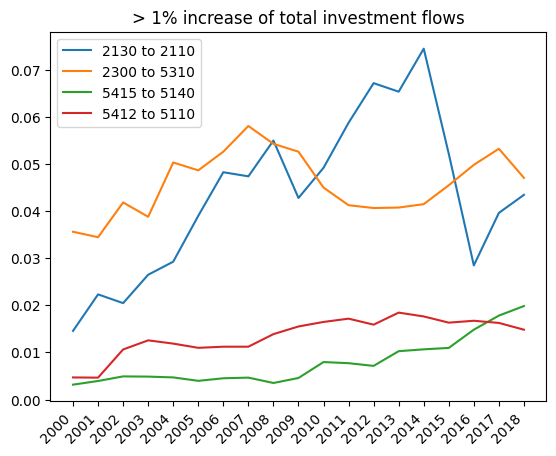

In [26]:
# support activities for mining (2130) to oil and gas extraction (2110)
# construction (2300) to real estate (5310)
# computer systems design (5415) to information and data processing services (5140)
# miscellaneous professiona services (5412) to publishing industries, includes software (5110)
ir.plot_top_flows(norm_bea, years, sectors)

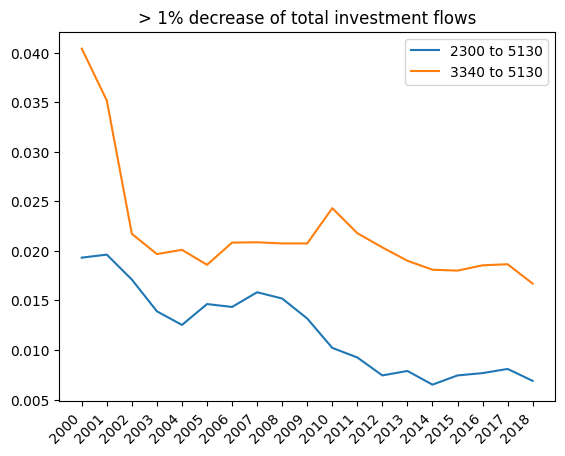

In [27]:
# construction (2300) to broadcasting and telecommunications (5130)
# computer and electronic products (3340) to broadcasting and telecommunications (5130)
ir.plot_bot_flows(norm_bea, years, sectors)

#### Total Production


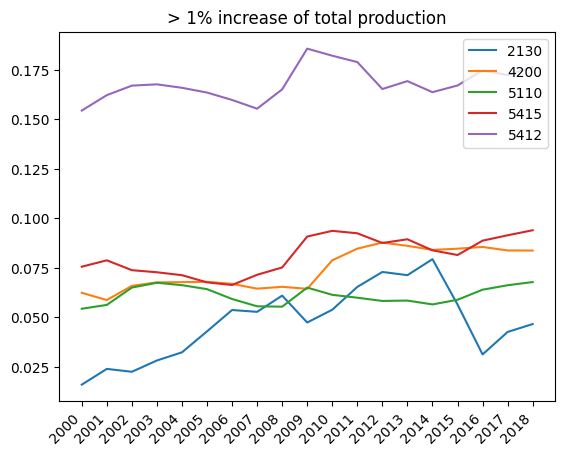

In [28]:
# support activities for mining (2130)
# wholesale trade (4200)
# publishing industries, including software (5110)
# computer systems design (5415)
# miscellaneous professional services (5412)
ir.plot_top_prod(norm_bea, years, sectors)

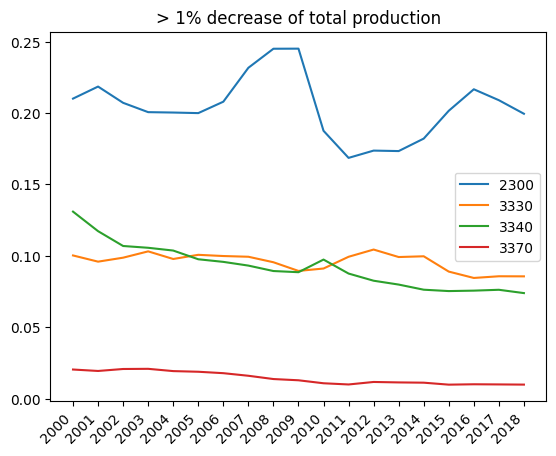

In [29]:
# construction (2300)
# machinery (3330)
# computer and electronic products (3340)
# furniture and related products (3370)
ir.plot_bot_prod(norm_bea, years, sectors)

#### Total Expenditure

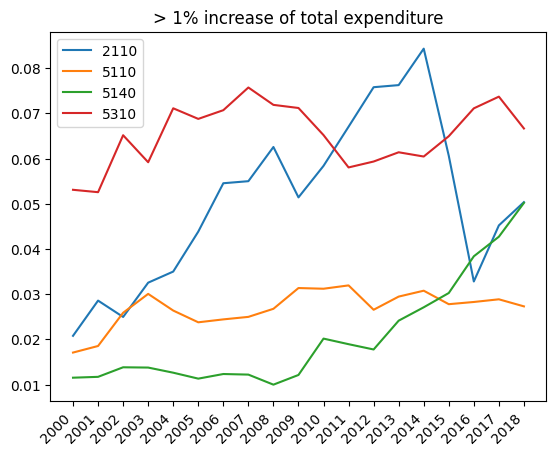

In [30]:
# oil and gas extraction (2110)
# publishing industries, including software (5110)
# information and data processing services (5140)
# real estate (5310)
ir.plot_top_expend(norm_bea, years, sectors)

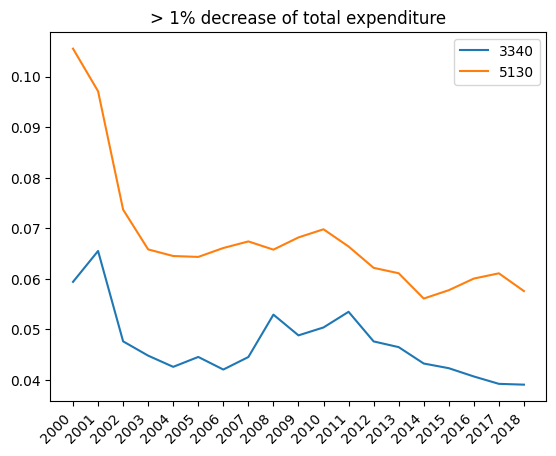

In [31]:
# computer and electronic products (3340)
# broadcasting and telecommunications (5130)
ir.plot_bot_expend(norm_bea, years, sectors)

### Matrix Transformation to OECD

$$R_{(41\times 41)t}=A_{(41\times 63)t}V_{(63\times 63)t}B_{(63\times 41)t}$$

Where A sums and splits rows such that rows are split according to the relative weight of total production (e.g. if $j=Chemical Products$ is being split into $i=Chemicals$, which produces 80% ($A_{ij}=.8$) and $i=Pharmaceuticals$, which produces 20% of capital ($A_{ij}=.2$)). B averages and splits columns such that the averages are weighted according to their total expenditure.

In the code, A assumes uniform production when splitting industry rows. Since the only row sector that gets split into two when going from BEA to ICIO sectors is Chemical Products, it is corrected for after the fact.

In [32]:
# create dictionary map between oecd and bea
oecd_bea = bo.crosswalk_map(crosswalk_df)
# get total expenditure in order to weight the averaging of columns into OECD aggregates
bea_total_exp = ir.get_total_expend_weights(expend_df, years)
# get chemical/pharmaceutical split from BEA's chemical to OECD's two categories
chemical_split = ir.get_chemical_split(icio_folder, years)

In [33]:
oecd_recipe = ir.create_oecd_matrix_series(final_bea, oecd_bea, bea_total_exp, chemical_split, years, sectors)

In [34]:
# sum over years and display
oecd_agg = pd.DataFrame(oecd_recipe.sum(axis = 0))
oecd_agg.columns = list(oecd_bea.keys())
oecd_agg.index = list(oecd_bea.keys())   
px.imshow(oecd_agg, width=800, height=800)

## International Investment Matrix

### ICIO-based

$I$ is the international investment matrix where $al$ is the producing sector $l$ in country $a$ and $bm$ is the consuming sector $m$ in country $b$.

$$I_{(al)(bm)t}$$

We have $P_{(al)bt}$ from the ICIO, total production for each country/sector $al$ that is consumed by each country $b$ at time $t$, and we have $R_{lmt}$, the intensive form of the inter sectoral investment recipe based on Vom-Lehn Winberry where $\sum_{l,m}R_{lmt}=\mathbb{1_t}$. For each pair of countries $a_0$ and $b_0$, we use $P_{(al)bt}$ to empirically weight $R_{lmt}$. We do this by taking the sum of $P_{(a_0l)b_0t}$ which is the total investment flows produced by $a_0$ and consumed by $b_0$ at time $t$.

$$R_{l_0m_0t}=R_{lmt}\sum_{l}{P_{(a_0 l)b_0t}}$$

This results in a sectoral investment matrix $R_{l_0m_0t}$ between $a_0$ and $b_0$, where $l_0 \subset l$ and $m_0\subset m$ are the sectors corresponding to $a_0$ and $b_0$. This approach doesn't make use of the full granularity of the data since we're summing the total sectoral production for each pair of countries $P_{(al)bt}$. When done for all pairs of countries, $a$ and $b$, we get an extensive international investment matrix $I_{(al)(bm)t}$, such that each region corresponding to pairs of countries $a_0$ and $b_0$ sum to $\sum_{l}{P_{(a_0 l)b_0t}}$.

Finally, to get the country/sector $bm$ investment distributions, we divide each column of $I_{(al)(bm)t}$ by it's sum, so that the column sums are equal to 1.

In [35]:
countries, country_sectors = inet.get_countries(icio_folder, oecd_bea)
inter_flows, inter_mat = inet.icio_international_series(icio_folder, oecd_bea, oecd_recipe, years)

100%|██████████| 19/19 [04:10<00:00, 13.19s/it]


In [37]:
icio_df = pd.read_csv(f"{icio_folder}/ICIO2021_{years[0]}.csv")
gfcf_cols = icio_df.columns[icio_df.columns.map(lambda x: "GFCF" in x)]

#### Testing and Saving by Year

In [50]:
# column normalize each year so we get expenditure shares
norm_inter_mat = np.zeros(inter_mat.shape)
for y in tqdm(range(inter_mat.shape[0])):

    icio_df = pd.read_csv(f"{icio_folder}/ICIO2021_{years[y]}.csv", index_col=0)
    gfcf_cols = icio_df.columns[icio_df.columns.map(lambda x: "GFCF" in x)]

    for a in countries:
        
        if a in ["MEX", "CHN"]:
            continue
        
        for b in countries: 

            if b in ["MEX", "CHN"]:
                continue
            
            temp = pd.DataFrame(inter_mat[y,:,:])
            temp.columns = country_sectors
            temp.index = country_sectors

            invmat_val = temp.loc[
                temp.index.map(lambda x: a in x),
                temp.columns.map(lambda x: b in x),
            ]
            
            icio_val = icio_df.loc[
                icio_df.index.map(lambda x: x in invmat_val.index),
                icio_df.columns.map(lambda x: "GFCF" in x and b in x),
            ]

            # print("inv: ", invmat_val.shape)
            # print("icio: ", icio_val.shape)

            # print("inv: ", invmat_val.sum().sum())
            # print("icio: ", icio_val.sum().sum())
            # print("flow: ", inter_flows[y,list(countries).index(a),list(countries).index(b)])

            try:
                # check matches to the nearest 1,000 USD
                assert round(invmat_val.sum().sum(), 3) == round(icio_val.sum().sum(), 3)
            except Exception as e:
                print("a: ", a, " b: ", b)
                print("inv: ", invmat_val.sum().sum())
                print("icio: ", icio_val.sum().sum())


    norm_inter_mat[y,:,:] = inter_mat[y,:,:] / inter_mat[y,:,:].sum(axis=0)

    temp = pd.DataFrame(inter_mat[y,:,:])
    temp.columns = country_sectors
    temp.index = country_sectors
    temp.to_csv(f"processed_data/final_matrices/invmat_ext_{years[y]}.csv")

    temp = pd.DataFrame(norm_inter_mat[y,:,:])
    temp.columns = country_sectors
    temp.index = country_sectors
    temp.to_csv(f"processed_data/final_matrices/invmat_int_{years[y]}.csv")


In [41]:
inter_flows_agg = pd.DataFrame(inter_flows.sum(axis = 0))
inter_flows_agg.columns = countries
inter_flows_agg.index = countries
px.imshow(np.log(inter_flows_agg), width=500, height=500)

#### The Final International Investment Matrix

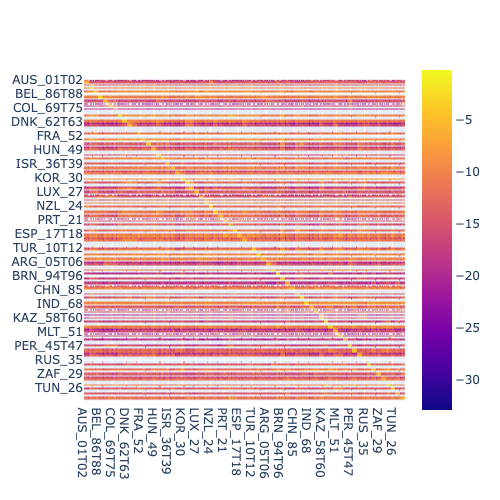

In [42]:
inter_mat_agg = pd.DataFrame(norm_inter_mat.sum(axis = 0))
inter_mat_agg.columns = country_sectors
inter_mat_agg.index = country_sectors
np.save("processed_data/international_investment_matrix_series.npy", norm_inter_mat)
# scale columns to 1 (e.g. averaging over the years)
inter_mat_agg = inter_mat_agg / inter_mat_agg.sum()
inter_mat_agg.to_csv("processed_data/international_investment_matrix.csv")
# px.imshow(np.log(inter_mat_agg), width=500, height=500)
# this loses a significant amount of detail due to plotly's granularity
# to see it without loss, generate the figure with width and height >8000
Image("processed_data/int_inv_net1.png")

### Analyzing Changes in Inter-Country Network 

In [43]:
norm_inter = np.zeros(inter_flows.shape)
for i in range(len(years)):
    norm_inter[i,:,:] = inter_flows[i,:,:] / inter_flows[i,:,:].sum().sum()

#### Total Country Production

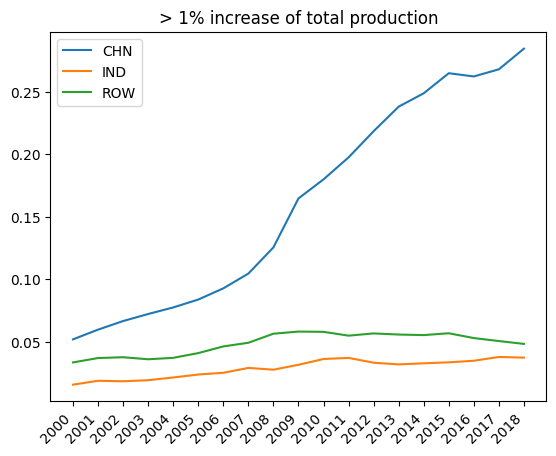

In [44]:
ir.plot_top_prod(norm_inter, years, countries)

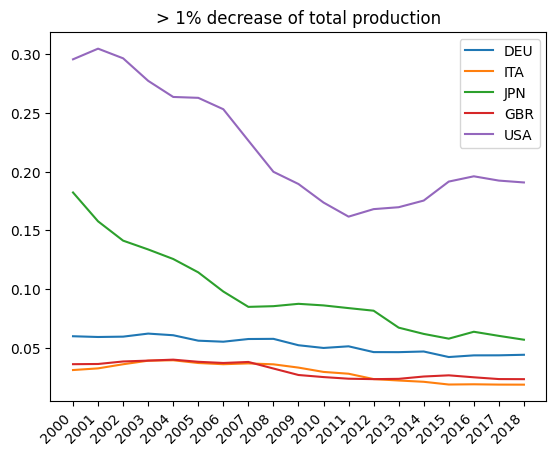

In [45]:
ir.plot_bot_prod(norm_inter, years, countries)

#### Total Country Expenditure

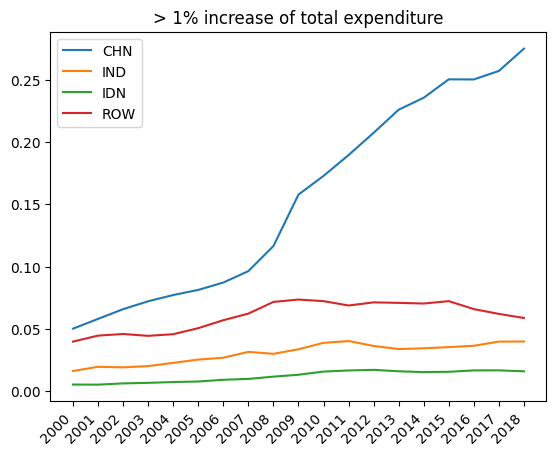

In [46]:
ir.plot_top_expend(norm_inter, years, countries)

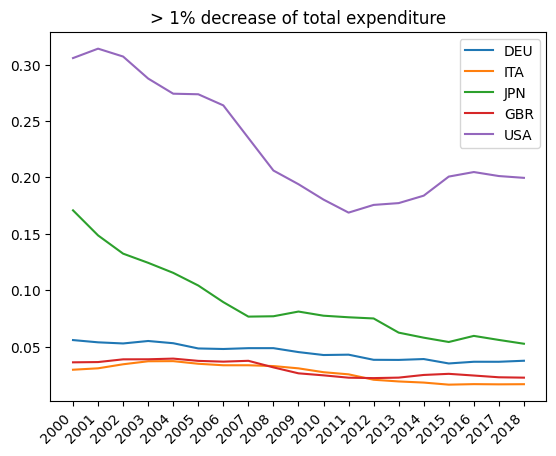

In [47]:
ir.plot_bot_expend(norm_inter, years, countries)

### Using ICIO + OECD Capital Formation

Again, $I$ is the international investment matrix where $al$ is the producing sector $l$ in country $a$ and $bm$ is the consuming sector $m$ in country $b$.

$$I_{(al)(bm)}$$

We have $P_{(al)b}$ from the ICIO, total production for each country/sector $al$ that is consumed by each country $b$, and we have $R_{lm}$, the intensive form of the inter sectoral investment recipe based on Vom-Lehn Winberry where $\sum_{l,m}R_{lm}=1$. In addition, we use $E_{bm}$, total capital formation for each consuming country/sector $bm$, from the OECD. For each pair of countries $a_0$ and $b_0$, we can use these to get estimates for $I_{(a_0l)(b_0m)}$ using iterative proportional fitting. First, we take $P_{(a_0l)b_0}$ as the row margins (e.g. total production) then we calculate the column margins as: 

$$\hat{E}_{b_0m}=\frac{E_{b_0m}}{\sum_{m}{E_{b_0m}}}\sum_{l}{P_{(a_0l)b_0}}$$

This ensures that the sum of the column margins $\hat{E}_{b_0m}$ is equal to the sum of the row margins. In other words, we're scaling down total expenditure of the country $b_0$ to match the expenditure of $b_0$ from $a_0$. The implicit assumption here is that the expenditure makeup of $b_0$ is the same for each country $a$ that it is consuming from.

We can now perform iterative proportional fitting:

$$(1)\quad R_{lm(k+1)}=(\frac{R_{lm(k)}}{\sum_jR_{lm(k)}}) P_{(a_0l)b_0}$$

$$(2)\quad R_{lm(k+2)}=(\frac{R_{lm(k+1)}}{\sum_iR_{lm(k)}}) \hat{E}_{b_0m}$$

This results in a better estimated international investment network $I_{(al)(bm)}$ where each country/sector, $al$ and $bm$ has an estimated marginal production and cost, respectively from which estimates are derived.

In [48]:
# sector_activity_map = inet.get_sector_activity_map(sector_activity_path)

# gfcf_df = inet.transform_gfcf(gfcf_path, exchange_path, sector_activity_map)
# inter_mat2 = inet.gfcf_international(f"{icio_folder}_ICIO2021_2014", oecd_recipe, gfcf_df, countries, country_sectors)

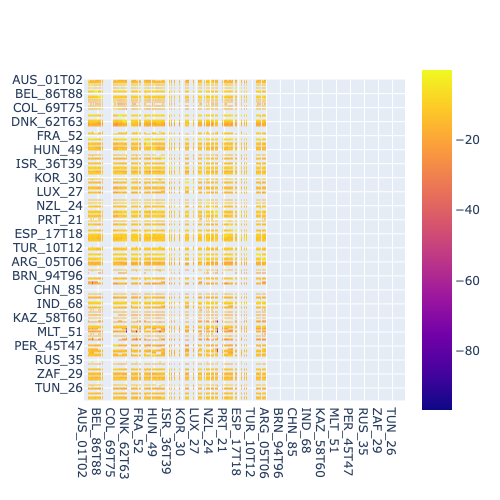

In [49]:
# px.imshow(inter_mat2, width=500, height=500)
Image("processed_data/int_inv_net2.png")

## Future Improvements

1. Improved BEA to OECD crosswalk: it's likely that it doesn't get much better than what we have but it would be good to match our mapping to how the OECD maps the US IOT data to their ICIO sectors
2. Country/Sector Expenditure: If we had total investment expenditure for each country/sector in the ICIO, we could perform the iterative proportional fitting described in the last section with more complete data
3. Non-uniform Transport Margins from Bridge File: If you can map each NIPA asset to a commodity code in the 2007/2012 detailed IOT tables, you could empirically split the transport margins in the same way it's currently done for pre-packaged software
4. Capital Formation Strategy Overtime: Currently, the international matrix strategy using capital formation is aggregated, not yearly
5. Depreciation of Capital: This isn't taken into account in this network construction. 